<a href="https://colab.research.google.com/github/Trantracy/A-Website-to-detect-VND-currency/blob/master/VND_Classifier_Optimized_with_tf_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VND Classifier

Tonga 2020

## Get data

Import important libraries and set constants for paths of our data raw, train and test sets.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import shutil # copy, move file
import os # miscellaneous operation system interfaces
import pathlib
import tensorflow as tf
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

import random

tf.random.set_seed(102)
np.random.seed(102)

DATA_ROOT_FOLDER = "/content/drive/My Drive/FTMLE - Tonga/Week_8/VND_classifier/building_model/data"
DATA_RAW_FOLDER = "/content/drive/My Drive/FTMLE - Tonga/Week_8/VND_classifier/building_model/data/raw"
DATA_TRAIN_FOLDER = "/content/drive/My Drive/FTMLE - Tonga/Week_8/VND_classifier/building_model/data/train"
DATA_TEST_FOLDER = "/content/drive/My Drive/FTMLE - Tonga/Week_8/VND_classifier/building_model/data/test"

In [0]:
print('TensorFLow version:', tf.__version__)
print('GPU available:', tf.test.is_gpu_available())

TensorFLow version: 2.2.0-rc4
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU available: False


In [0]:
def create_folder_or_reset_folder(folder_path):
    if os.path.isdir(folder_path):
        shutil.rmtree(folder_path)
        os.mkdir(folder_path)
        print('Removed and created', folder_path)
    else:
        os.mkdir(folder_path)
        print('Created new', folder_path)
    
    for folder_name in class_names:
        os.mkdir(os.path.join(folder_path, folder_name))
        
def clean_ipynb_folder_if_exists(folder=DATA_ROOT_FOLDER):
    folder = pathlib.Path(folder)
    ipynb_paths = [str(item) for item in folder.glob('**/*') if item.is_dir() and item.name.startswith('.ipynb')]
    if len(ipynb_paths) > 0:
        for eachdir in ipynb_paths:
            shutil.rmtree(eachdir)
            print("Removed", eachdir)
    else:
        print('No .ipynb_checkpoints to remove')


In [0]:
# Clean .ipynb_checkpoints
clean_ipynb_folder_if_exists()

No .ipynb_checkpoints to remove


In [0]:
raw_folder =  pathlib.Path(DATA_RAW_FOLDER)
class_names = [str(item.name) for item in raw_folder.glob('*/') if item.is_dir()]
print(class_names)
class_names = np.array(sorted(class_names, key=lambda x: int(x)))

NUM_CLASSES = len(class_names)

all_image_paths = [str(item) for item in raw_folder.glob('*/*') if item.is_file()]
all_image_labels = [str(item.parent.name) for item in raw_folder.glob('*/*') if item.is_file()]

assert len(all_image_paths) == len(all_image_labels)

['20000', '10000', '2000', '5000', '50000', '100000', '1000', '200000', '500000']


In [0]:
# Create empty train and test folder
create_folder_or_reset_folder(DATA_TRAIN_FOLDER)
create_folder_or_reset_folder(DATA_TEST_FOLDER)

Removed and created /content/drive/My Drive/FTMLE - Tonga/Week_8/VND_classifier/building_model/data/train
Removed and created /content/drive/My Drive/FTMLE - Tonga/Week_8/VND_classifier/building_model/data/test


In [0]:
from sklearn.model_selection import train_test_split

train_image_paths, test_image_paths, train_image_labels, test_image_labels = train_test_split(all_image_paths, all_image_labels, test_size=0.2, random_state=101)

print('Split data: {} for training and {} for testing'.format(len(train_image_paths), len(test_image_paths)))

Split data: 1232 for training and 308 for testing


In [0]:
assert len(train_image_paths) + len(test_image_paths) == len(all_image_paths)

### Preprocess image

* Resize the image to (192, 192)
* Demean the image

In [0]:
IMAGE_WIDTH, IMAGE_HEIGHT = 192, 192

def resize_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMAGE_WIDTH, IMAGE_HEIGHT])
    return image

def load_and_resize_image(path):
    image = tf.io.read_file(path)
    return resize_image(image)

def images_preprocessing_and_saving(folder_path, image_paths, image_labels):
    new_paths = []
    for index, image_path in enumerate(image_paths):
        try:
            file_name = '{}.jpg'.format(index)
            new_path = os.path.join(folder_path, image_labels[index], file_name)
            preprocessed_image = load_and_resize_image(image_path)
            tf.keras.preprocessing.image.save_img(new_path, preprocessed_image, data_format='channels_last')
            new_paths.append(new_path)
            if (index % 100 == 0) and (index > 0):
                print('Processed {} images '.format(index))
        except:
            print("File error {}".format(image_path))
    return new_paths

def show_batch(image_batch, label_batch):
    '''Show batch of 25 images.
    
    Parameters:
        image_batch: paths to the images, len(image_path) >= 25
        label_batch: labels of the images (str)
    '''
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(label_batch[n].title())
        plt.axis('off')

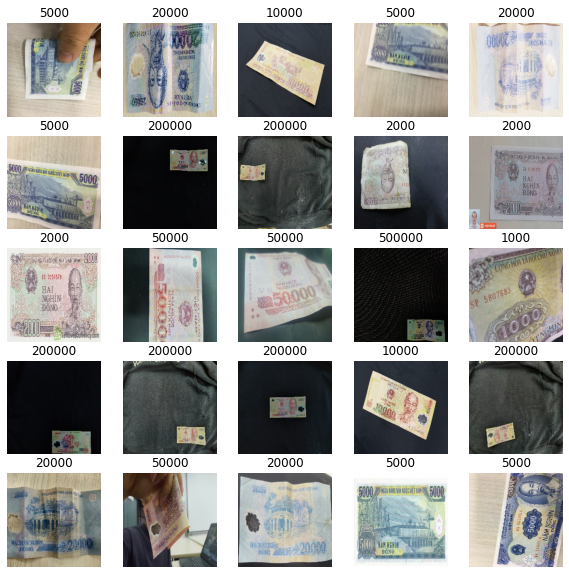

In [0]:
image_batch = [load_and_resize_image(path)/255 for path in train_image_paths[:25]]
label_batch = train_image_labels[:25]
show_batch(image_batch , label_batch)

In [0]:
train_image_paths = images_preprocessing_and_saving(DATA_TRAIN_FOLDER, train_image_paths, train_image_labels)

Processed 100 images 
Processed 200 images 
Processed 300 images 
Processed 400 images 
Processed 500 images 
Processed 600 images 
Processed 700 images 
Processed 800 images 
Processed 900 images 
Processed 1000 images 
Processed 1100 images 
Processed 1200 images 


In [0]:
test_image_paths = images_preprocessing_and_saving(DATA_TEST_FOLDER, test_image_paths, test_image_labels)

Processed 100 images 
Processed 200 images 
Processed 300 images 


Test the number of images in folders matching with original number of images

In [0]:
print(len(train_image_paths), len(test_image_paths))
!ls ../data/train/*/* | wc -l
!ls ../data/test/*/* | wc -l

1229 308
1232
308


In [0]:
TRAIN_SAMPLES = 1229
TEST_SAMPLES = 308
BATCH_SIZE = 32

AUTOTUNE = tf.data.experimental.AUTOTUNE
STEPS_PER_TRAIN_EPOCH = tf.math.ceil(TRAIN_SAMPLES/BATCH_SIZE)
STEPS_PER_TEST_EPOCH = tf.math.ceil(TEST_SAMPLES/BATCH_SIZE)

In [0]:
train_ds = tf.data.Dataset.list_files(os.path.join(DATA_TRAIN_FOLDER, '*','*'))
test_ds = tf.data.Dataset.list_files(os.path.join(DATA_TEST_FOLDER, '*','*'))

for f in train_ds.take(5):
    print(f.numpy())

def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    return parts[-2] == class_names

def preprocess(path):
    label = get_label(path)
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = (image*2) - 1  # normalize to [-1,1] range
    image = tf.image.per_image_standardization(image)
    return image, label

def augmentation(image, label):
    image = tf.image.random_brightness(image, .1)
    image = tf.image.random_contrast(image, lower=0.0, upper=1.0)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image, label
    
def prepare_for_training(ds, cache=True, shuffle_buffer_size=100, augment=False):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    
    if augment:
        ds.map(augmentation, num_parallel_calls=AUTOTUNE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = train_ds.map(preprocess, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(preprocess, num_parallel_calls=AUTOTUNE)

for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

b'../data/train/50000/915.jpg'
b'../data/train/10000/295.jpg'
b'../data/train/100000/803.jpg'
b'../data/train/500000/1011.jpg'
b'../data/train/5000/1088.jpg'
Image shape:  (192, 192, 3)
Label:  [False False False False False False False  True False]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

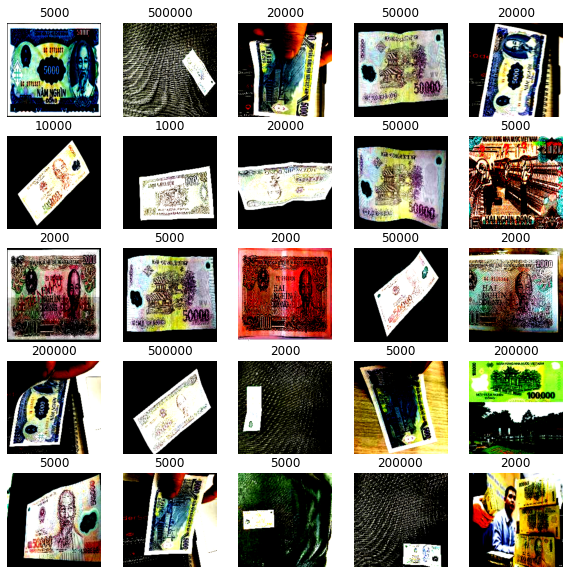

In [0]:
train_ds = prepare_for_training(train_ds, shuffle_buffer_size=TRAIN_SAMPLES, augment=True)
test_ds = prepare_for_training(test_ds, cache=False, shuffle_buffer_size=TEST_SAMPLES)

image_batch, label_batch = next(iter(train_ds))
label_batch = [class_names[np.argmax(label)] for label in label_batch.numpy()]
show_batch(image_batch, label_batch)

## Transfer Learning

In [0]:
mobile_net = tf.keras.applications.MobileNetV2(input_shape=(192, 192, 3), include_top=False)
mobile_net.trainable=False

model = tf.keras.Sequential([
    mobile_net,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(NUM_CLASSES, activation = 'softmax')])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_192 (Model) (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 9)                 11529     
Total params: 2,269,513
Trainable params: 11,529
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
class CollectBatchStats(tf.keras.callbacks.Callback):
    def __init__(self):
        self.batch_losses = []
        self.batch_acc = []
        self.batch_val_losses = []
        self.batch_val_acc = []

    def on_train_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['acc'])
        # reset_metrics: the metrics returned will be only for this batch. 
        # If False, the metrics will be statefully accumulated across batches.
        self.model.reset_metrics()
  
    def on_test_batch_end(self, batch, logs=None):
        self.batch_val_losses.append(logs['loss'])
        self.batch_val_acc.append(logs['acc'])
        # reset_metrics: the metrics returned will be only for this batch. 
        # If False, the metrics will be statefully accumulated across batches.
        self.model.reset_metrics()

def plot_stats(training_stats, val_stats, x_label='Training Steps', stats='loss'):
    stats, x_label = stats.title(), x_label.title()
    legend_loc = 'upper right' if stats=='loss' else 'lower right'
    training_steps = len(training_stats)
    test_steps = len(val_stats)

    plt.figure()
    plt.ylabel(stats)
    plt.xlabel(x_label)
    plt.plot(training_stats, label='Training ' + stats)
    plt.plot(np.linspace(0, training_steps, test_steps), val_stats, label='Validation ' + stats)
    plt.ylim([0,max(plt.ylim())])
    plt.legend(loc=legend_loc)
    plt.show()

batch_stats_callback = CollectBatchStats()

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer= tf.keras.optimizers.RMSprop(lr=0.0001),
              metrics=['acc'])

num_steps_train = tf.math.ceil(float(TRAIN_SAMPLES)/BATCH_SIZE)              
num_steps_val = tf.math.ceil(float(TEST_SAMPLES)/BATCH_SIZE)              

history = model.fit(train_ds,
                    steps_per_epoch = num_steps_train,
                    epochs=10,
                    validation_data = test_ds,
                    validation_steps = num_steps_val,
                    callbacks=[batch_stats_callback],
                    initial_epoch=0)

Train for 39.0 steps, validate for 10.0 steps
Epoch 1/10
39/39 [==============================] - 8s 213ms/step - loss: 2.2678 - acc: 0.2812 - val_loss: 2.2523 - val_acc: 0.1875
Epoch 2/10
39/39 [==============================] - 1s 30ms/step - loss: 1.8137 - acc: 0.4688 - val_loss: 1.9640 - val_acc: 0.1875
Epoch 3/10
39/39 [==============================] - 1s 31ms/step - loss: 1.5239 - acc: 0.6562 - val_loss: 1.7862 - val_acc: 0.2812
Epoch 4/10
39/39 [==============================] - 1s 31ms/step - loss: 1.2765 - acc: 0.6250 - val_loss: 1.6028 - val_acc: 0.4062
Epoch 5/10
39/39 [==============================] - 1s 30ms/step - loss: 1.0663 - acc: 0.7500 - val_loss: 1.4438 - val_acc: 0.4375
Epoch 6/10
39/39 [==============================] - 1s 31ms/step - loss: 0.9253 - acc: 0.8125 - val_loss: 1.3441 - val_acc: 0.3438
Epoch 7/10
39/39 [==============================] - 1s 31ms/step - loss: 0.7980 - acc: 0.8750 - val_loss: 1.2136 - val_acc: 0.5938
Epoch 8/10
39/39 [==================

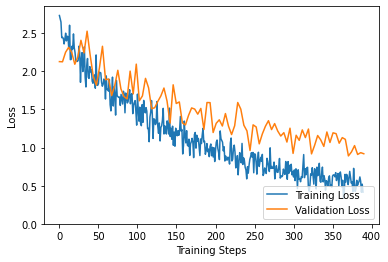

In [0]:
plot_stats(batch_stats_callback.batch_losses, batch_stats_callback.batch_val_losses, stats='loss')

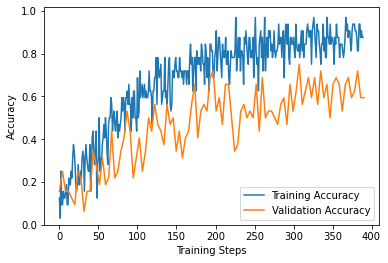

In [0]:
plot_stats(batch_stats_callback.batch_acc, batch_stats_callback.batch_val_acc, stats='accuracy')

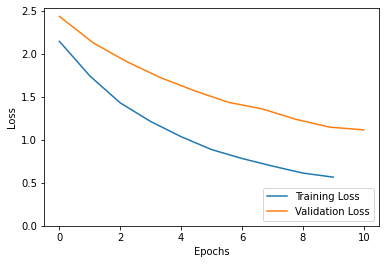

In [0]:
plot_stats(history.history['loss'], history.history['val_loss'], x_label='Epochs', stats='loss')

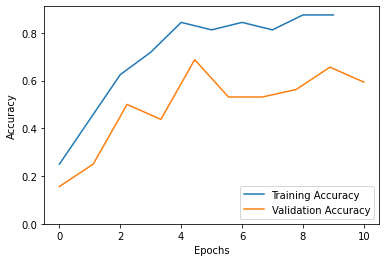

In [0]:
plot_stats(history.history['acc'], history.history['val_acc'], x_label='Epochs', stats='accuracy')

## Fine-tuning

In [0]:
mobile_net.trainable=True

print("Number of layers in the base model:", len(mobile_net.layers))

fine_tune_at = 140

for layer in mobile_net.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model: 155


In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer= tf.keras.optimizers.RMSprop(lr=0.0001),
              metrics=['acc'])

history_ft = model.fit(train_ds,
                    steps_per_epoch = num_steps_train,
                    epochs=15,
                    validation_data = test_ds,
                    validation_steps = num_steps_val,
                    callbacks=[batch_stats_callback],
                    initial_epoch=10)

Train for 39.0 steps, validate for 10.0 steps
Epoch 11/15
39/39 [==============================] - 4s 114ms/step - loss: 0.2553 - acc: 1.0000 - val_loss: 0.6755 - val_acc: 0.7812
Epoch 12/15
39/39 [==============================] - 1s 33ms/step - loss: 0.0603 - acc: 1.0000 - val_loss: 0.6003 - val_acc: 0.8125
Epoch 13/15
39/39 [==============================] - 1s 33ms/step - loss: 0.0189 - acc: 1.0000 - val_loss: 0.5519 - val_acc: 0.9062
Epoch 14/15
39/39 [==============================] - 1s 33ms/step - loss: 0.0127 - acc: 1.0000 - val_loss: 0.4611 - val_acc: 0.8750
Epoch 15/15
39/39 [==============================] - 1s 33ms/step - loss: 0.0058 - acc: 1.0000 - val_loss: 0.4117 - val_acc: 0.7812


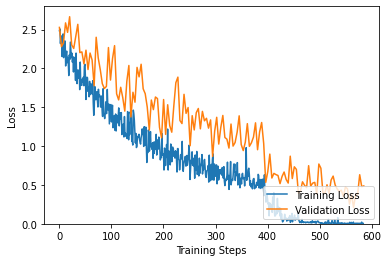

In [0]:
plot_stats(batch_stats_callback.batch_losses, batch_stats_callback.batch_val_losses, stats='loss')

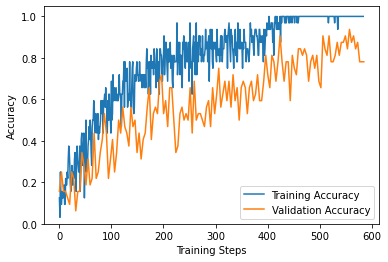

In [0]:
plot_stats(batch_stats_callback.batch_acc, batch_stats_callback.batch_val_acc, stats='accuracy')

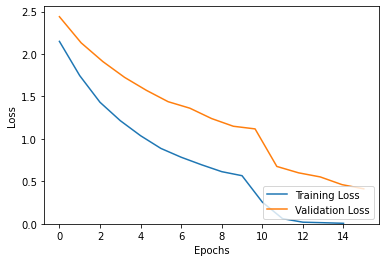

In [0]:
plot_stats(history.history['loss'] + history_ft.history['loss'], 
           history.history['val_loss']+ history_ft.history['val_loss'], 
           x_label='Epochs', stats='loss')

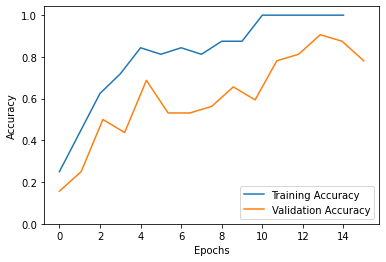

In [0]:
plot_stats(history.history['acc'] + history_ft.history['acc'], 
           history.history['val_acc']+ history_ft.history['val_acc'], 
           x_label='Epochs', stats='accuracy')

In [0]:
model.save('./model/vnd_classifier.h5')

## Analyze Error

In [0]:
reloaded_model = tf.keras.models.load_model('./model/vnd_classifier.h5')
reloaded_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_192 (Model) (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 11529     
Total params: 2,269,513
Trainable params: 1,051,529
Non-trainable params: 1,217,984
_________________________________________________________________


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

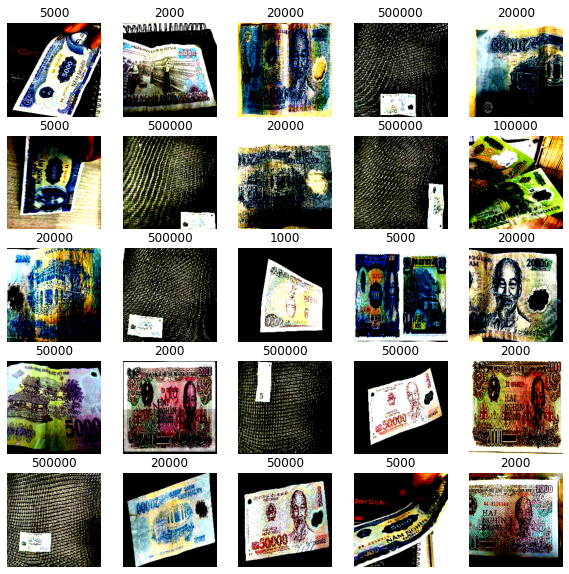

In [0]:
image_batch, label_batch = next(iter(train_ds))
label_batch = [class_names[np.argmax(label)] for label in label_batch.numpy()]
show_batch(image_batch, label_batch)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

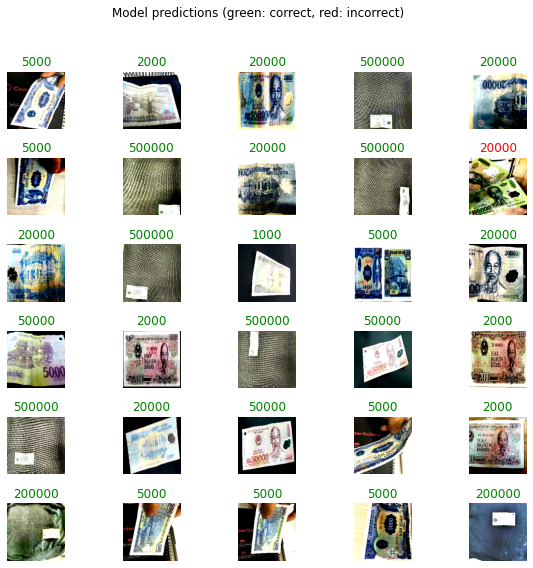

In [0]:
predicted_batch = reloaded_model.predict(image_batch)
predicted_label = np.argmax(predicted_batch, axis=1)
predicted_label = [class_names[idx] for idx in predicted_label]
# Plot the result

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow((image_batch[n]+1)/2)
    color = "green" if predicted_label[n] == label_batch[n] else "red"
    plt.title(predicted_label[n], color=color)
    plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

## Compared the train speed with ImageGenerator

In [0]:
#Load data using ImageGenerator

import pandas as pd

train_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest"
)
test_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

train_generator = train_image_generator.flow_from_directory(
                        DATA_TRAIN_FOLDER,
                        target_size=(192, 192),
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        seed=102,
                        class_mode='sparse')
test_generator = test_image_generator.flow_from_directory(
                        DATA_TEST_FOLDER,
                        target_size=(192, 192),
                        batch_size=BATCH_SIZE,
                        shuffle=False,
                        class_mode='sparse')



Found 1229 images belonging to 9 classes.
Found 308 images belonging to 9 classes.


In [0]:
mobile_net = tf.keras.applications.MobileNetV2(input_shape=(192, 192, 3), include_top=False)
mobile_net.trainable=False

model = tf.keras.Sequential([
    mobile_net,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(NUM_CLASSES, activation = 'softmax')])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_192 (Model) (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1280)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 9)                 11529     
Total params: 2,269,513
Trainable params: 11,529
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
TRAIN_SAMPLES

1229

In [0]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer= tf.keras.optimizers.RMSprop(lr=0.0001),
              metrics=['acc'])

num_steps_train = math.ceil(float(TRAIN_SAMPLES)/BATCH_SIZE)              
num_steps_val = math.ceil(float(TEST_SAMPLES)/BATCH_SIZE)              

model.fit_generator(train_generator,
          steps_per_epoch = num_steps_train,
          epochs=10,
          validation_data = test_generator,
          validation_steps = num_steps_val,
          callbacks=[batch_stats_callback])

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 39 steps, validate for 10 steps
Epoch 1/10
39/39 [==============================] - 14s 355ms/step - loss: 2.1522 - acc: 0.1250 - val_loss: 2.2176 - val_acc: 0.2000
Epoch 2/10
39/39 [==============================] - 11s 282ms/step - loss: 1.7929 - acc: 0.4375 - val_loss: 2.0540 - val_acc: 0.2500
Epoch 3/10
39/39 [==============================] - 11s 283ms/step - loss: 1.5468 - acc: 0.5385 - val_loss: 1.9129 - val_acc: 0.3500
Epoch 4/10
39/39 [==============================] - 11s 284ms/step - loss: 1.3491 - acc: 0.4688 - val_loss: 1.8012 - val_acc: 0.6000
Epoch 5/10
39/39 [==============================] - 11s 282ms/step - loss: 1.1640 - acc: 0.7812 - val_loss: 1.7092 - val_acc: 0.8500
Epoch 6/10
39/39 [==============================] - 11s 282ms/step - loss: 1.0303 - acc: 0.8125 - val_loss: 1.6503 - val_acc: 0.9500
Epoch 7/10
39/39 [================

In [0]:
mobile_net.trainable=True

print("Number of layers in the base model:", len(mobile_net.layers))

fine_tune_at = 140

for layer in mobile_net.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model: 155


In [0]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_192 (Model) (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1280)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 9)                 11529     
Total params: 1,229,513
Trainable params: 11,529
Non-trainable params: 1,217,984
_________________________________________________________________


In [0]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer= tf.keras.optimizers.RMSprop(lr=0.0001),
              metrics=['acc'])

model.fit_generator(train_generator,
          steps_per_epoch = num_steps_train,
          epochs=15
                    ,
          validation_data = test_generator,
          validation_steps = num_steps_val,
          callbacks=[batch_stats_callback])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 39 steps, validate for 10 steps
Epoch 1/15
39/39 [==============================] - 14s 359ms/step - loss: 0.3475 - acc: 1.0000 - val_loss: 1.0956 - val_acc: 1.0000
Epoch 2/15
39/39 [==============================] - 11s 284ms/step - loss: 0.1523 - acc: 1.0000 - val_loss: 0.9694 - val_acc: 1.0000
Epoch 3/15
39/39 [==============================] - 11s 284ms/step - loss: 0.0904 - acc: 1.0000 - val_loss: 0.8758 - val_acc: 1.0000
Epoch 4/15
39/39 [==============================] - 11s 282ms/step - loss: 0.0590 - acc: 1.0000 - val_loss: 0.8732 - val_acc: 1.0000
Epoch 5/15
39/39 [==============================] - 11s 281ms/step - loss: 0.0403 - acc: 1.0000 - val_loss: 0.8825 - val_acc: 1.0000
Epoch 6/15
39/39 [==============================] - 11s 282ms/step - loss: 0.0254 - acc: 1.0000 - val_loss: 0.7902 - val_acc: 1.0000
Epoch 7/15
39/39 [==============================] - 11s 279ms/step - loss: 0.0243 - acc: 1.0000 - val_loss: 0.